# Data analysis
This jupyter notebook will quanitfy and analyze the alpha generated by different actively managed mutual funds.  These mutual funds were chosen through a process that Richard will detail.

The goal of the project is two-fold.
- Determine the portion of returns for a given strategy that arises from exposure to various market or systematic risk factors
- Identify and quanityf the 'idiosyncratic alpha'

In [1]:
from tools import get_mutual_fund_data, get_bond_data, get_ff_data, get_index_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from data_tools import capm, ff_3, ff_5, reg_date_range, capm_index, corr_index

Total number of categories 20
Total number of funds: 1698

Mutual Fund Data


c:\Users\dklro\Documents\Fall 2023\15.433\15-4331-final-project\tools.py:129: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/mutual_funds/mutual_fund_data.csv",skiprows=0).dropna(how='any')


Total number of rows: 408031
Total number of funds with enough data: 1608
Funds with no data: 25
Funds with less than 5 years of data: 65
Columns: Index(['ticker', 'date', 'total_net_assets', 'total_returns',
       'net_asset_value', 'nav_return'],
      dtype='object')


In [2]:
pd.set_option('display.max_rows', 10)

## Import data
First, we import data using the tools that Richard wrote.  This allows us to get mutual fund data in a dictionary.  In addition, we also want FF factors and CAPM factors to do some basic analysis

In [3]:
mf_dict = get_mutual_fund_data()
ff_df = get_ff_data()
bond_df = get_bond_data()
index_dict = get_index_data()


Mutual Fund Data


c:\Users\dklro\Documents\Fall 2023\15.433\15-4331-final-project\tools.py:129: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/mutual_funds/mutual_fund_data.csv",skiprows=0).dropna(how='any')


Total number of rows: 408031
Total number of funds with enough data: 1608
Funds with no data: 25
Funds with less than 5 years of data: 65
Columns: Index(['ticker', 'date', 'total_net_assets', 'total_returns',
       'net_asset_value', 'nav_return'],
      dtype='object')

FF Data
          date  Mkt-RF   SMB   HML   RMW   CMA    RF
0   1963-07-31   -0.39 -0.41 -0.97  0.68 -1.18  0.27
1   1963-08-31    5.07 -0.80  1.80  0.36 -0.35  0.25
2   1963-09-30   -1.57 -0.52  0.13 -0.71  0.29  0.27
3   1963-10-31    2.53 -1.39 -0.10  2.80 -2.01  0.29
4   1963-11-30   -0.85 -0.88  1.75 -0.51  2.24  0.27
..         ...     ...   ...   ...   ...   ...   ...
719 2023-06-30    6.46  1.34 -0.26  2.18 -1.62  0.40
720 2023-07-31    3.21  2.86  4.11 -0.57  0.57  0.45
721 2023-08-31   -2.39 -3.65 -1.06  3.43 -2.37  0.45
722 2023-09-30   -5.24 -1.80  1.52  1.86 -0.83  0.43
723 2023-10-31   -3.18 -4.03  0.19  2.47 -0.66  0.47

[724 rows x 7 columns]

Bond Data
Columns: Index(['date', '30 Year Bond Return', '

In [4]:
len(mf_dict)

1608

## Data set
Let us first take a look at our data set to see what we are working with.  We are only working with actively managed funds and primarily those with the largest AUM.

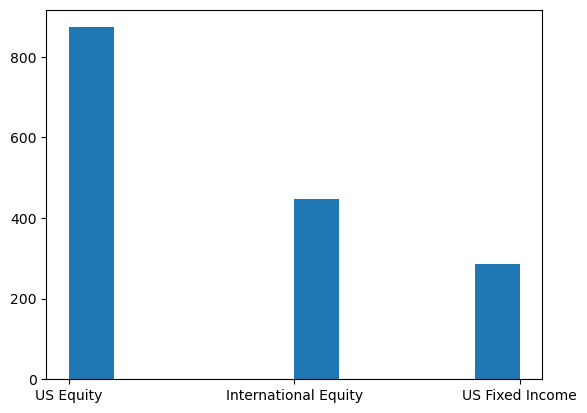

In [5]:
mf_types = list(mf_dict.keys())
mf_areas = [arr[1] for arr in mf_types]
plt.hist(mf_areas)
plt.show()

### Example df below

In [6]:
mf_dict[mf_types[10]]

,ticker,date,total_net_assets,total_returns,net_asset_value,nav_return
0,LBSCX,2002-12-31,0.100,-0.043162,8.4900000,NaN
1,LBSCX,2003-01-31,0.100,-0.029446,8.2400000,-0.029446
2,LBSCX,2003-02-28,0.100,-0.055825,7.7800000,-0.055825
3,LBSCX,2003-03-31,0.200,0.001303,7.7800000,0.000000
4,LBSCX,2003-04-30,0.200,0.073265,8.3500000,0.073265
...,...,...,...,...,...,...
245,LBSCX,2023-05-31,1231.500,-0.029601,27.2100000,-0.029601
246,LBSCX,2023-06-30,1290.600,0.058508,28.7300000,0.055862
247,LBSCX,2023-07-31,1326.400,0.034807,29.7300000,0.034807
248,LBSCX,2023-08-31,1284.600,-0.022200,29.0700000,-0.022200


## US Equity
First, let us look at those actively managed US equity funds

### Get US Equity Data specifically

In [7]:
mf_types = list(mf_dict.keys())
us_eq_data = {k[2]:[] for k in mf_dict.keys() if 'US Equity' in k}

for mf_key, mf_val in mf_dict.items():
    if mf_key[2] in us_eq_data.keys():
        us_eq_data[mf_key[2]].append(mf_val)

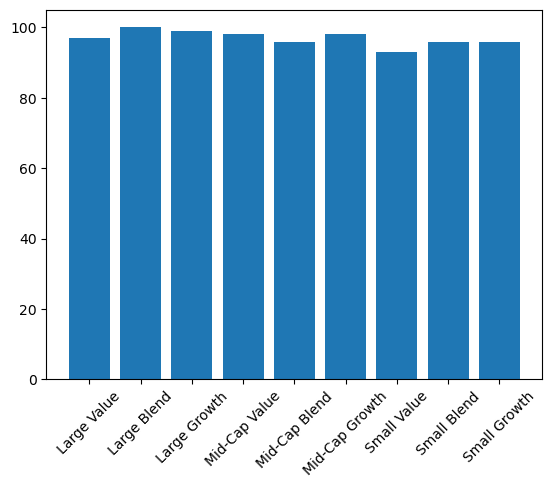

In [8]:
us_amount = [len(arr) for arr in us_eq_data.values()]
plt.bar(us_eq_data.keys(), us_amount)
plt.xticks(rotation=45)
plt.show()

### CAPM
First, we run CAPM on each to find their beta and alpha.  This gives us a good baseline with which to work off of.  

Note that these are run allowing for herteroskedasticity.  They are also run for the full range of dates for now

#### CAPM on all listed companies
F-F data file used here

This takes an average of all mututal fund alpha and betas in a certain category

In [9]:
# Example usage of the capm function
capm(us_eq_data['Large Blend'][0], ff_df)

{'const': -0.4729943515703532, 'Mkt-RF': 0.8108697503318263}

In [10]:
us_eq_alphas_c = []
us_eq_betas_c = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    for ticker in us_eq_data[strat]:
        result = capm(ticker, ff_df)
        if result == None:
            continue
        temp_alpha.append(result['const'])
        temp_beta.append(result['Mkt-RF'])
    us_eq_alphas_c.append(np.mean(temp_alpha))
    us_eq_betas_c.append(np.mean(temp_beta))

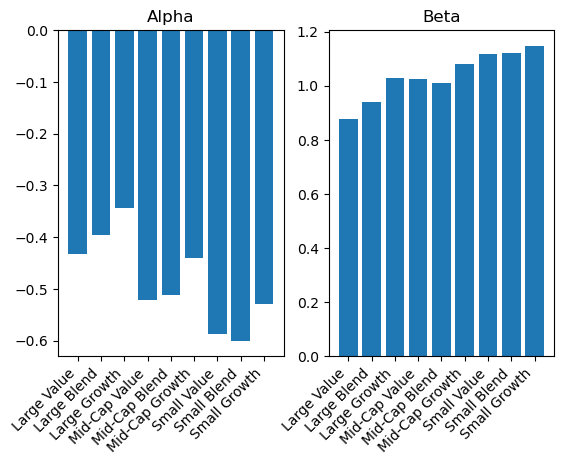

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(us_eq_data.keys(), us_eq_alphas_c)
ax2.bar(us_eq_data.keys(), us_eq_betas_c)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()

#### CAPM on benchmark
Here instead we consider the market return as the benchmark index return

This again takes an average of all mutual fund alpha and beta within a category with the market return as benchmark

In [12]:
us_index = {k[2]: v for k, v in index_dict.items() if 'US Equity' in k}

In [13]:
us_idx_alphas_c = []
us_idx_betas_c = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    for ticker in us_eq_data[strat]:
        start_date = ff_df['date'][0] if ff_df['date'][0] > ticker['date'][1] else ticker['date'][1]
        start_date = start_date if start_date > us_index[strat]['Date'][1] else us_index[strat]['Date'][1]
        end_date = ticker['date'].iloc[-1]
        result = capm_index(ticker, ff_df, us_index[strat], start_date, end_date)
        if result == None:
            continue
        temp_alpha.append(result['const'])
        temp_beta.append(result['beta'])
    us_idx_alphas_c.append(np.mean(temp_alpha))
    us_idx_betas_c.append(np.mean(temp_beta))

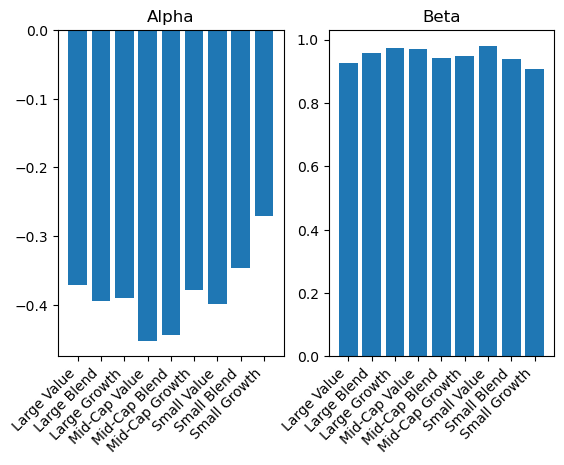

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(us_eq_data.keys(), us_idx_alphas_c)
ax2.bar(us_eq_data.keys(), us_idx_betas_c)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()

### FF 3-Factor
This is the 3-factor model including SMB and HML

In [15]:
us_alphas_3 = []
us_betas_3 = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    for ticker in us_eq_data[strat]:
        start_date = ff_df['date'][0] if ff_df['date'][0] > ticker['date'][1] else ticker['date'][1]
        start_date = start_date if start_date > us_index[strat]['Date'][1] else us_index[strat]['Date'][1]
        end_date = ticker['date'].iloc[-1]
        result = reg_date_range(ticker, ff_df, ['Mkt-RF', 'SMB', 'HML'], start_date, end_date)
        if result == None:
            continue
        temp_alpha.append(result['const'])
    us_alphas_3.append(np.mean(temp_alpha))

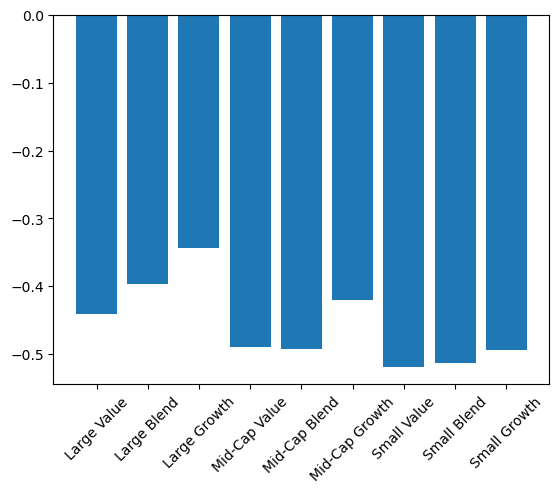

In [16]:
plt.bar(us_eq_data.keys(), us_alphas_3)
plt.xticks(rotation=45)
plt.show()

### FF 5-Factor
This is the 3-factor model including SMB and HML.  RMW and CMA as well

In [17]:
us_alphas_5 = []
us_betas_5 = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    for ticker in us_eq_data[strat]:
        start_date = ff_df['date'][0] if ff_df['date'][0] > ticker['date'][1] else ticker['date'][1]
        start_date = start_date if start_date > us_index[strat]['Date'][1] else us_index[strat]['Date'][1]
        end_date = ticker['date'].iloc[-1]
        result = reg_date_range(ticker, ff_df, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], start_date, end_date)
        if result == None:
            continue
        temp_alpha.append(result['const'])
    us_alphas_5.append(np.mean(temp_alpha))

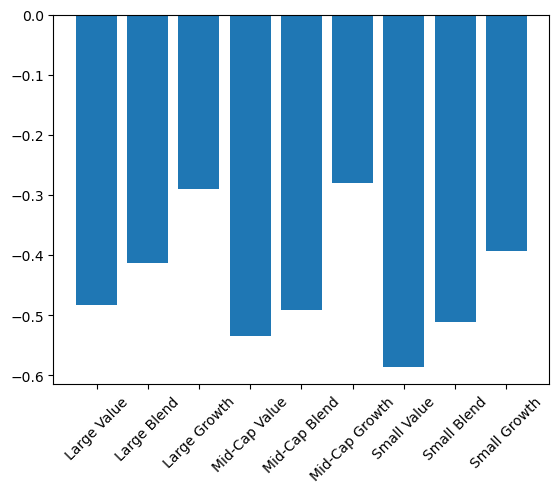

In [18]:
plt.bar(us_eq_data.keys(), us_alphas_5)
plt.xticks(rotation=45)
plt.show()

### Combined bar graph of alpha from FF and CAPM

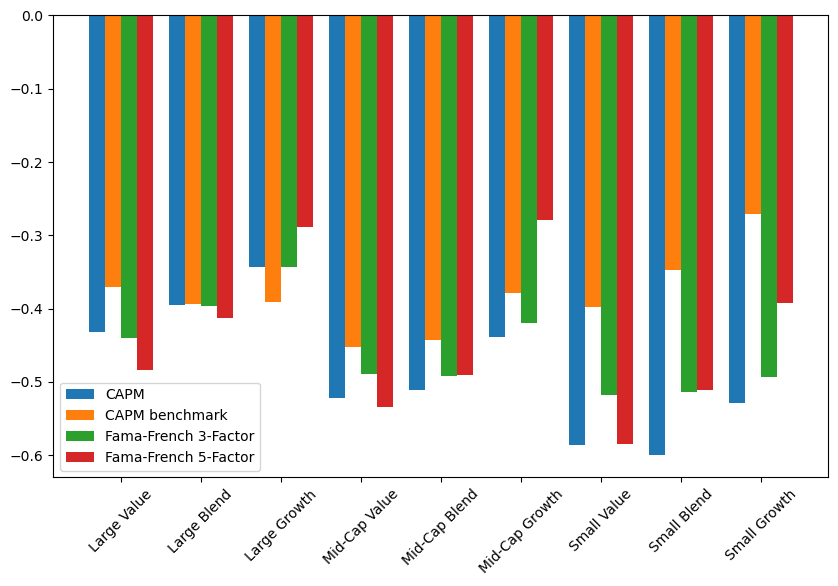

In [19]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

idx = np.arange(len(us_eq_data.keys()))


ax.bar(idx-0.3, us_eq_alphas_c, 0.2, label='CAPM')
ax.bar(idx-0.1, us_idx_alphas_c, 0.2, label='CAPM benchmark')
ax.bar(idx+0.1, us_alphas_3, 0.2, label='Fama-French 3-Factor')
ax.bar(idx+0.3, us_alphas_5, 0.2, label='Fama-French 5-Factor')


ax.set_xticks(idx)
ax.set_xticklabels(us_eq_data.keys(), rotation=45)
ax.legend()
plt.show()

### Find results from date range
We can now look at the results from a data range more specifically.  The function below is an example of being able to do that

Probably looking at a date range after GFC and before Covid has the least randomness or impact of systematic risk.  Could do more looking into regions of low vol.

In [20]:
between_alpha = []
gfc_alpha = []
covid_alpha = []

for strat in us_eq_data.keys():
    temp_between_alpha=[]
    temp_gfc_alpha = []
    temp_covid_alpha = []
    for ticker in us_eq_data[strat]:
        result = reg_date_range(ticker, ff_df, ['Mkt-RF'], '20100101', '20200101')
        if result == None:
            pass
        else:
            temp_between_alpha.append(result['const'])

        result = reg_date_range(ticker, ff_df, ['Mkt-RF'], '20071201', '20090601')
        if result == None:
            pass
        else:
            temp_gfc_alpha.append(result['const'])

        result = reg_date_range(ticker, ff_df, ['Mkt-RF'], '20200201', '20220101')
        if result == None:
            pass
        else:
            temp_covid_alpha.append(result['const'])
    
    between_alpha.append(np.mean(temp_between_alpha))
    gfc_alpha.append(np.mean(temp_gfc_alpha))
    covid_alpha.append(np.mean(temp_covid_alpha))

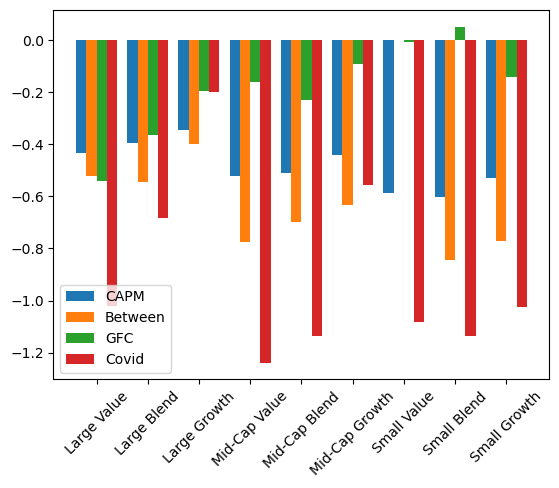

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx = np.arange(len(us_eq_data.keys()))


ax.bar(idx-0.3, us_eq_alphas_c, 0.2, label='CAPM')
ax.bar(idx-0.1, between_alpha, 0.2, label='Between')
ax.bar(idx+0.1, gfc_alpha, 0.2, label='GFC')
ax.bar(idx+0.3, covid_alpha, 0.2, label='Covid')

ax.set_xticks(idx)
ax.set_xticklabels(us_eq_data.keys(), rotation=45)
ax.legend()
plt.show()

### Correlations between MF and benchmark

In [26]:
us_corr = []
for strat in us_eq_data.keys():
    temp_corr=[]
    for ticker in us_eq_data[strat]:
        start_date = ticker['date'][1] if ticker['date'][1] > us_index[strat]['Date'][1] else us_index[strat]['Date'][1]
        end_date = ticker['date'].iloc[-1]
        result = corr_index(ticker, us_index[strat], start_date, end_date)
        if result == None:
            continue
        temp_corr.append(result)
    us_corr.append(np.mean(temp_corr))

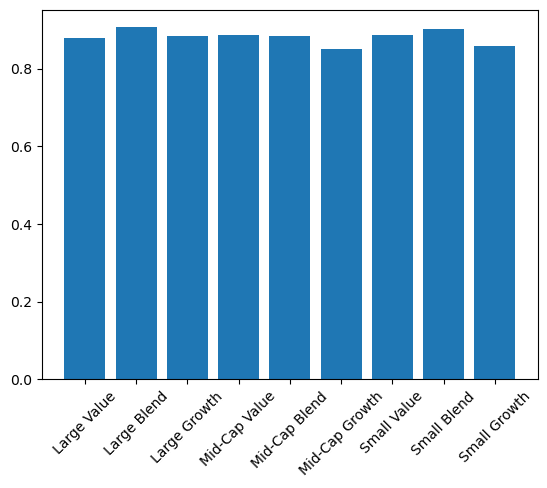

In [27]:
plt.bar(us_eq_data.keys(), us_corr)
plt.xticks(rotation=45)
plt.show()

## International Equity
Next, we will look at international equity funds

## NOTE THIS IS USELESS CAUSE HAVE NOT REWRITTEN IT

### Get international Equity Data specifically

In [23]:
mf_types = list(mf_dict.keys())
int_data = {k[2]: v for k, v in mf_dict.items() if 'International Equity' in k}
print(f'List of types of mutual funds being considered: {int_data.keys()}')

List of types of mutual funds being considered: dict_keys(['Foreign Large Value', 'Foreign Large Blend', 'Foreign Large Growth', 'Foreign SmallMid Value', 'Foreign SmallMid Blend', 'Foreign SmallMid Growth', 'Diversified Emerging Mkts'])


### CAPM
First, we run CAPM on each to find their beta and alpha.  This gives us a good baseline with which to work off of.  

Note that these are run allowing for herteroskedasticity.  They are also run for the full range of dates for now

Also note that CAPM does not make a ton of sense here beacuse we are comparing international returns to the US markets, and how much it makes above that

In [24]:
int_alphas, int_betas, int_names = capm(int_data, ff_df)

KeyError: 'date'

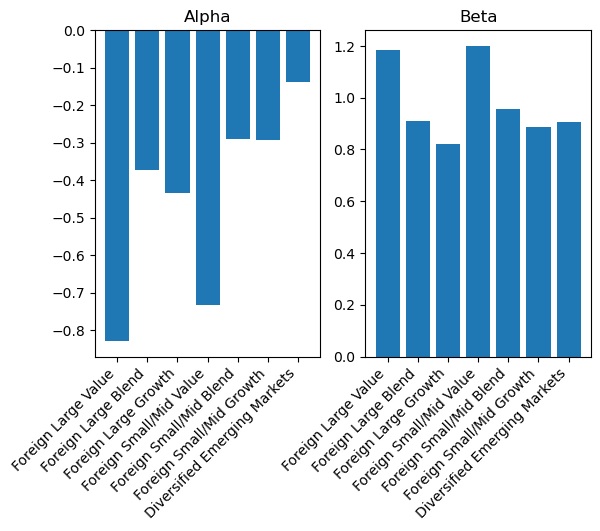

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(int_names, int_alphas)
ax2.bar(int_names, int_betas)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()

## TODO
CAPM w/ benchmark index 

CAPM and FF on different date ranges (look at whether alpha specifically lower during Covid and GFC) (Limit range to between GFC and Covid)

Correlation to benchmark

Identify specifically positive alpha mutual funds, or those which have higher than average

correlation v alpha